# <span style="color: red">! ! ! Don't run these blocks of cells.</span>
- <b>Augmentation</b>
- <b>Create and compile model</b>
- <b>Train model modules</b>

# Imports

In [1]:
import os
import time
from glob import glob
from tqdm import tqdm
from collections import Counter

import numpy as np

from PIL import ImageDraw, Image, ImageFont
import matplotlib.pyplot as plt
from matplotlib import image as m_image
%matplotlib inline

import cv2

import tensorflow as tf
import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

from keras.models import Sequential, Model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import DBSCAN

import pytesseract  # in windows you need to install tesseract before pip install pytesseract

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

# An example of dataset

In [3]:
path = 'Train//'

In [4]:
folder_id = 15  # 0 - 77, no 36
img_id = 10  # other numbers

In [5]:
img = cv2.imread(path + str(folder_id) + "\\" + str(img_id) + ".png")
img.shape

(64, 64, 3)

In [6]:
img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_g.shape

(64, 64)

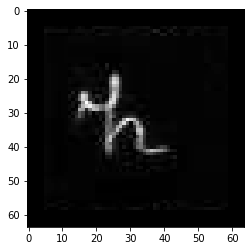

In [7]:
plt.imshow(img_g, cmap='gray');

# Read and prepare dataset

In [8]:
#Classes
n_classes = 77
letters = 'Ա Բ Գ Դ Ե Զ Է Ը Թ Ժ Ի Լ Խ Ծ Կ Հ Ձ Ղ Ճ Մ Յ Ն Շ Ո Չ Պ Ջ Ռ Ս Վ Տ Ր Ց ՈՒ Փ Ք ԵՎ Օ Ֆ \
           ա բ գ դ ե զ է ը թ ժ ի լ խ ծ կ հ ձ ղ ճ մ յ ն շ ո չ պ ջ ռ ս վ տ ր ց ու փ ք և օ ֆ'
letters_list = letters.split()
for i in letters_list:
    print(i, end=' ')

Ա Բ Գ Դ Ե Զ Է Ը Թ Ժ Ի Լ Խ Ծ Կ Հ Ձ Ղ Ճ Մ Յ Ն Շ Ո Չ Պ Ջ Ռ Ս Վ Տ Ր Ց ՈՒ Փ Ք ԵՎ Օ Ֆ ա բ գ դ ե զ է ը թ ժ ի լ խ ծ կ հ ձ ղ ճ մ յ ն շ ո չ պ ջ ռ ս վ տ ր ց ու փ ք և օ ֆ 

In [9]:
activity_map = {}
for i, j in enumerate(letters_list):
    activity_map[i] = j
del activity_map[36]
activity_map

{0: 'Ա',
 1: 'Բ',
 2: 'Գ',
 3: 'Դ',
 4: 'Ե',
 5: 'Զ',
 6: 'Է',
 7: 'Ը',
 8: 'Թ',
 9: 'Ժ',
 10: 'Ի',
 11: 'Լ',
 12: 'Խ',
 13: 'Ծ',
 14: 'Կ',
 15: 'Հ',
 16: 'Ձ',
 17: 'Ղ',
 18: 'Ճ',
 19: 'Մ',
 20: 'Յ',
 21: 'Ն',
 22: 'Շ',
 23: 'Ո',
 24: 'Չ',
 25: 'Պ',
 26: 'Ջ',
 27: 'Ռ',
 28: 'Ս',
 29: 'Վ',
 30: 'Տ',
 31: 'Ր',
 32: 'Ց',
 33: 'ՈՒ',
 34: 'Փ',
 35: 'Ք',
 37: 'Օ',
 38: 'Ֆ',
 39: 'ա',
 40: 'բ',
 41: 'գ',
 42: 'դ',
 43: 'ե',
 44: 'զ',
 45: 'է',
 46: 'ը',
 47: 'թ',
 48: 'ժ',
 49: 'ի',
 50: 'լ',
 51: 'խ',
 52: 'ծ',
 53: 'կ',
 54: 'հ',
 55: 'ձ',
 56: 'ղ',
 57: 'ճ',
 58: 'մ',
 59: 'յ',
 60: 'ն',
 61: 'շ',
 62: 'ո',
 63: 'չ',
 64: 'պ',
 65: 'ջ',
 66: 'ռ',
 67: 'ս',
 68: 'վ',
 69: 'տ',
 70: 'ր',
 71: 'ց',
 72: 'ու',
 73: 'փ',
 74: 'ք',
 75: 'և',
 76: 'օ',
 77: 'ֆ'}

In [10]:
# Resizing images size using cv2
def read_resize_image(path, img_rows, img_cols, color_type=1):
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

In [11]:
# Train Images
def load_data(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    for classed in tqdm(range(n_classes)):
        if classed == 36:
            continue
        print(f'Loading directory {classed}')
        files = glob(os.path.join( 'C:\\Users\\user\\Desktop\\DL\\Project\\Train\\' + str(classed), '*.png'))
#         files = glob(os.path.join( 'C:\\Users\\Asus\\Desktop\\DL\\Train\\' + str(classed), '*.png'))
        for file in files:
            img = read_resize_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
            
    end_time = time.time()
    print(f"Data Loaded in {(end_time - start_time) // 60} minutes, {round(end_time - start_time) % 60} seconds")
    
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    return train_images, train_labels

In [12]:
# Normalizing Train Images
def read_norm_split_data(img_rows, img_cols, color_type, test_size=0.2, random_state=42):
    X, labels = load_data(img_rows, img_cols, color_type)
    
    x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(X, labels, test_size=test_size, random_state=random_state)
    
    x_train = x_train_0 / 255
    x_test = x_test_0 / 255
    
    y_train = np_utils.to_categorical(y_train_0, n_classes)
    y_test = np_utils.to_categorical(y_test_0, n_classes)
    
    x_train = np.array(x_train).reshape(-1, img_rows, img_cols, color_type)
    x_test = np.array(x_test).reshape(-1, img_rows, img_cols, color_type)
    
    return x_train, x_test, y_train, y_test, y_train_0, y_test_0

In [13]:
img_rows = 64
img_cols = 64
color_type = 1

test_size = 0.2
random_st = 42

In [14]:
x_train, x_test, y_train, y_test, y_train_0, y_test_0 = read_norm_split_data(img_rows, img_cols, color_type, test_size=test_size, random_state=random_st)

  0%|          | 0/77 [00:00<?, ?it/s]

Loading directory 0


  1%|▏         | 1/77 [00:03<04:30,  3.56s/it]

Loading directory 1


  3%|▎         | 2/77 [00:07<04:35,  3.67s/it]

Loading directory 2


  4%|▍         | 3/77 [00:11<04:38,  3.76s/it]

Loading directory 3


  5%|▌         | 4/77 [00:14<04:26,  3.65s/it]

Loading directory 4


  6%|▋         | 5/77 [00:18<04:32,  3.78s/it]

Loading directory 5


  8%|▊         | 6/77 [00:22<04:30,  3.81s/it]

Loading directory 6


  9%|▉         | 7/77 [00:26<04:36,  3.96s/it]

Loading directory 7


 10%|█         | 8/77 [00:31<04:46,  4.15s/it]

Loading directory 8


 12%|█▏        | 9/77 [00:36<04:55,  4.35s/it]

Loading directory 9


 13%|█▎        | 10/77 [00:40<04:56,  4.43s/it]

Loading directory 10


 14%|█▍        | 11/77 [00:44<04:45,  4.33s/it]

Loading directory 11


 16%|█▌        | 12/77 [00:49<04:41,  4.33s/it]

Loading directory 12


 17%|█▋        | 13/77 [00:53<04:35,  4.31s/it]

Loading directory 13


 18%|█▊        | 14/77 [00:58<04:37,  4.40s/it]

Loading directory 14


 19%|█▉        | 15/77 [01:01<04:22,  4.24s/it]

Loading directory 15


 21%|██        | 16/77 [01:06<04:33,  4.48s/it]

Loading directory 16


 22%|██▏       | 17/77 [01:11<04:34,  4.57s/it]

Loading directory 17


 23%|██▎       | 18/77 [01:16<04:24,  4.49s/it]

Loading directory 18


 25%|██▍       | 19/77 [01:20<04:17,  4.44s/it]

Loading directory 19


 26%|██▌       | 20/77 [01:25<04:17,  4.52s/it]

Loading directory 20


 27%|██▋       | 21/77 [01:29<04:05,  4.38s/it]

Loading directory 21


 29%|██▊       | 22/77 [01:33<04:03,  4.42s/it]

Loading directory 22


 30%|██▉       | 23/77 [01:38<04:03,  4.51s/it]

Loading directory 23


 31%|███       | 24/77 [01:42<03:52,  4.38s/it]

Loading directory 24


 32%|███▏      | 25/77 [01:46<03:48,  4.39s/it]

Loading directory 25


 34%|███▍      | 26/77 [01:51<03:43,  4.38s/it]

Loading directory 26


 35%|███▌      | 27/77 [01:55<03:40,  4.41s/it]

Loading directory 27


 36%|███▋      | 28/77 [02:00<03:41,  4.51s/it]

Loading directory 28


 38%|███▊      | 29/77 [02:05<03:38,  4.55s/it]

Loading directory 29


 39%|███▉      | 30/77 [02:09<03:31,  4.49s/it]

Loading directory 30


 40%|████      | 31/77 [02:14<03:33,  4.64s/it]

Loading directory 31


 42%|████▏     | 32/77 [02:19<03:28,  4.63s/it]

Loading directory 32


 43%|████▎     | 33/77 [02:23<03:21,  4.58s/it]

Loading directory 33


 44%|████▍     | 34/77 [02:27<03:15,  4.55s/it]

Loading directory 34


 45%|████▌     | 35/77 [02:32<03:08,  4.48s/it]

Loading directory 35


 47%|████▋     | 36/77 [02:36<03:02,  4.46s/it]

Loading directory 37


 49%|████▉     | 38/77 [02:40<02:12,  3.39s/it]

Loading directory 38


 51%|█████     | 39/77 [02:45<02:15,  3.56s/it]

Loading directory 39


 52%|█████▏    | 40/77 [02:49<02:22,  3.84s/it]

Loading directory 40


 53%|█████▎    | 41/77 [02:53<02:19,  3.87s/it]

Loading directory 41


 55%|█████▍    | 42/77 [02:57<02:16,  3.90s/it]

Loading directory 42


 56%|█████▌    | 43/77 [03:01<02:13,  3.91s/it]

Loading directory 43


 57%|█████▋    | 44/77 [03:05<02:12,  4.03s/it]

Loading directory 44


 58%|█████▊    | 45/77 [03:09<02:06,  3.94s/it]

Loading directory 45


 60%|█████▉    | 46/77 [03:14<02:07,  4.10s/it]

Loading directory 46


 61%|██████    | 47/77 [03:18<02:09,  4.30s/it]

Loading directory 47


 62%|██████▏   | 48/77 [03:23<02:08,  4.44s/it]

Loading directory 48


 64%|██████▎   | 49/77 [03:28<02:06,  4.52s/it]

Loading directory 49


 65%|██████▍   | 50/77 [03:32<02:02,  4.53s/it]

Loading directory 50


 66%|██████▌   | 51/77 [03:37<01:59,  4.60s/it]

Loading directory 51


 68%|██████▊   | 52/77 [03:42<01:53,  4.54s/it]

Loading directory 52


 69%|██████▉   | 53/77 [03:46<01:50,  4.59s/it]

Loading directory 53


 70%|███████   | 54/77 [03:51<01:45,  4.61s/it]

Loading directory 54


 71%|███████▏  | 55/77 [03:56<01:42,  4.66s/it]

Loading directory 55


 73%|███████▎  | 56/77 [04:00<01:38,  4.69s/it]

Loading directory 56


 74%|███████▍  | 57/77 [04:05<01:32,  4.62s/it]

Loading directory 57


 75%|███████▌  | 58/77 [04:09<01:25,  4.52s/it]

Loading directory 58


 77%|███████▋  | 59/77 [04:13<01:19,  4.43s/it]

Loading directory 59


 78%|███████▊  | 60/77 [04:18<01:17,  4.57s/it]

Loading directory 60


 79%|███████▉  | 61/77 [04:23<01:12,  4.54s/it]

Loading directory 61


 81%|████████  | 62/77 [04:27<01:05,  4.38s/it]

Loading directory 62


 82%|████████▏ | 63/77 [04:30<00:57,  4.12s/it]

Loading directory 63


 83%|████████▎ | 64/77 [04:34<00:51,  3.97s/it]

Loading directory 64


 84%|████████▍ | 65/77 [04:38<00:46,  3.90s/it]

Loading directory 65


 86%|████████▌ | 66/77 [04:42<00:43,  3.94s/it]

Loading directory 66


 87%|████████▋ | 67/77 [04:46<00:40,  4.01s/it]

Loading directory 67


 88%|████████▊ | 68/77 [04:50<00:36,  4.10s/it]

Loading directory 68


 90%|████████▉ | 69/77 [04:54<00:32,  4.11s/it]

Loading directory 69


 91%|█████████ | 70/77 [04:58<00:28,  4.10s/it]

Loading directory 70


 92%|█████████▏| 71/77 [05:02<00:24,  4.10s/it]

Loading directory 71


 94%|█████████▎| 72/77 [05:07<00:20,  4.18s/it]

Loading directory 72


 95%|█████████▍| 73/77 [05:11<00:16,  4.24s/it]

Loading directory 73


 96%|█████████▌| 74/77 [05:15<00:12,  4.11s/it]

Loading directory 74


 97%|█████████▋| 75/77 [05:19<00:07,  3.93s/it]

Loading directory 75


 99%|█████████▊| 76/77 [05:22<00:03,  3.79s/it]

Loading directory 76


100%|██████████| 77/77 [05:26<00:00,  4.24s/it]


Data Loaded in 5.0 minutes, 26 seconds


In [15]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape, y_train_0.shape, y_test_0.shape

((54624, 64, 64, 1),
 (13656, 64, 64, 1),
 (54624, 77),
 (13656, 77),
 (54624,),
 (13656,))

# <span style="color: red">!</span> Augmentation

In [21]:
datagen = ImageDataGenerator(rotation_range=10)#, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(x_train)

# <span style="color: red">!</span> Create and compile model

In [55]:
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_rows, img_cols, color_type)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(77, activation='softmax'))

    return model

In [68]:
lr_init = 0.001
batch_size = 64
epoch = 100

In [26]:
# # Get learning rate during training
# def get_lr_metric(optimizer):
#     def lr(y_true, y_pred):
#         return optimizer.lr
#     return lr

# optimizer = tf.keras.optimizers.Adamax(learning_rate=lr_init)
# lr_metric = get_lr_metric(optimizer)

In [70]:
optimizer_1 = tf.keras.optimizers.Adamax(learning_rate=lr_init)
loss_1 = 'categorical_crossentropy'
metrics_1 = ['accuracy'] #, lr_metric]

In [71]:
model = create_model()
model.summary()
model.compile(optimizer=optimizer_1, loss=loss_1, metrics=metrics_1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 64)        36928     
                                                      

In [72]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 30:
        lrate = 0.0005
    if epoch > 60:
        lrate = 0.0003
    if epoch > 80:
        lrate = 0.0001
    return lrate

In [73]:
# print(datagen.flow(x_train)[1706][0, :, :, :].shape)
# plt.imshow(datagen.flow(x_train)[1][10, :, :, :], cmap='gray');

# <span style="color: red">!</span> Train model

In [74]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                               steps_per_epoch=x_train.shape[0] // batch_size,
                              epochs=epoch,
#                               verbose=1,
                              validation_data=(x_test, y_test), 
                              callbacks=[LearningRateScheduler(lr_schedule)],
                              shuffle=True,
                             )

C:\Users\ASUS\AppData\Local\Temp/ipykernel_6848/2664584322.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/100
854/854 [==============================] - 41s 48ms/step - loss: 2.8066 - accuracy: 0.2799 - val_loss: 1.1417 - val_accuracy: 0.6997 - lr: 0.0010
Epoch 2/100
854/854 [==============================] - 40s 47ms/step - loss: 1.2803 - accuracy: 0.6323 - val_loss: 0.5736 - val_accuracy: 0.8327 - lr: 0.0010
Epoch 3/100
854/854 [==============================] - 40s 47ms/step - loss: 0.8483 - accuracy: 0.7500 - val_loss: 0.4402 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 4/100
854/854 [==============================] - 41s 47ms/step - loss: 0.6531 - accuracy: 0.8087 - val_loss: 0.3488 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 5/100
854/854 [==============================] - 42s 49ms/step - loss: 0.5467 - accuracy: 0.8379 - val_loss: 0.3149 - val_accuracy: 0.9064 - lr: 0.0010
Epoch 6/100
854/854 [==============================] - 41s 48ms/step - loss: 0.4716 - accuracy: 0.8612 - val_loss: 0.2821 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 7/100
854/854 [==============================]

854/854 [==============================] - 41s 48ms/step - loss: 0.0794 - accuracy: 0.9724 - val_loss: 0.2236 - val_accuracy: 0.9463 - lr: 5.0000e-04
Epoch 53/100
854/854 [==============================] - 41s 48ms/step - loss: 0.0755 - accuracy: 0.9734 - val_loss: 0.2214 - val_accuracy: 0.9483 - lr: 5.0000e-04
Epoch 54/100
854/854 [==============================] - 41s 48ms/step - loss: 0.0729 - accuracy: 0.9755 - val_loss: 0.2207 - val_accuracy: 0.9492 - lr: 5.0000e-04
Epoch 55/100
854/854 [==============================] - 41s 48ms/step - loss: 0.0743 - accuracy: 0.9743 - val_loss: 0.2268 - val_accuracy: 0.9484 - lr: 5.0000e-04
Epoch 56/100
854/854 [==============================] - 41s 48ms/step - loss: 0.0754 - accuracy: 0.9736 - val_loss: 0.2180 - val_accuracy: 0.9477 - lr: 5.0000e-04
Epoch 57/100
854/854 [==============================] - 41s 48ms/step - loss: 0.0731 - accuracy: 0.9745 - val_loss: 0.2120 - val_accuracy: 0.9468 - lr: 5.0000e-04
Epoch 58/100
854/854 [=============

# Load model

In [16]:
model_load = keras.models.load_model("model_weights/model_h5_95.h5")

# Predictions

In [17]:
y_pred = model_load.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)

y_pred_test_max_probas = np.max(y_pred, axis=1)

accuracy_score(y_test_0, y_pred_classes)

0.950058582308143

[[166   0   0 ...   0   1   0]
 [  0 180   0 ...   0   0   0]
 [  0   0 159 ...   0   0   0]
 ...
 [  0   0   0 ... 160   0   0]
 [  0   0   0 ...   0 170   0]
 [  0   0   0 ...   0   0 146]]


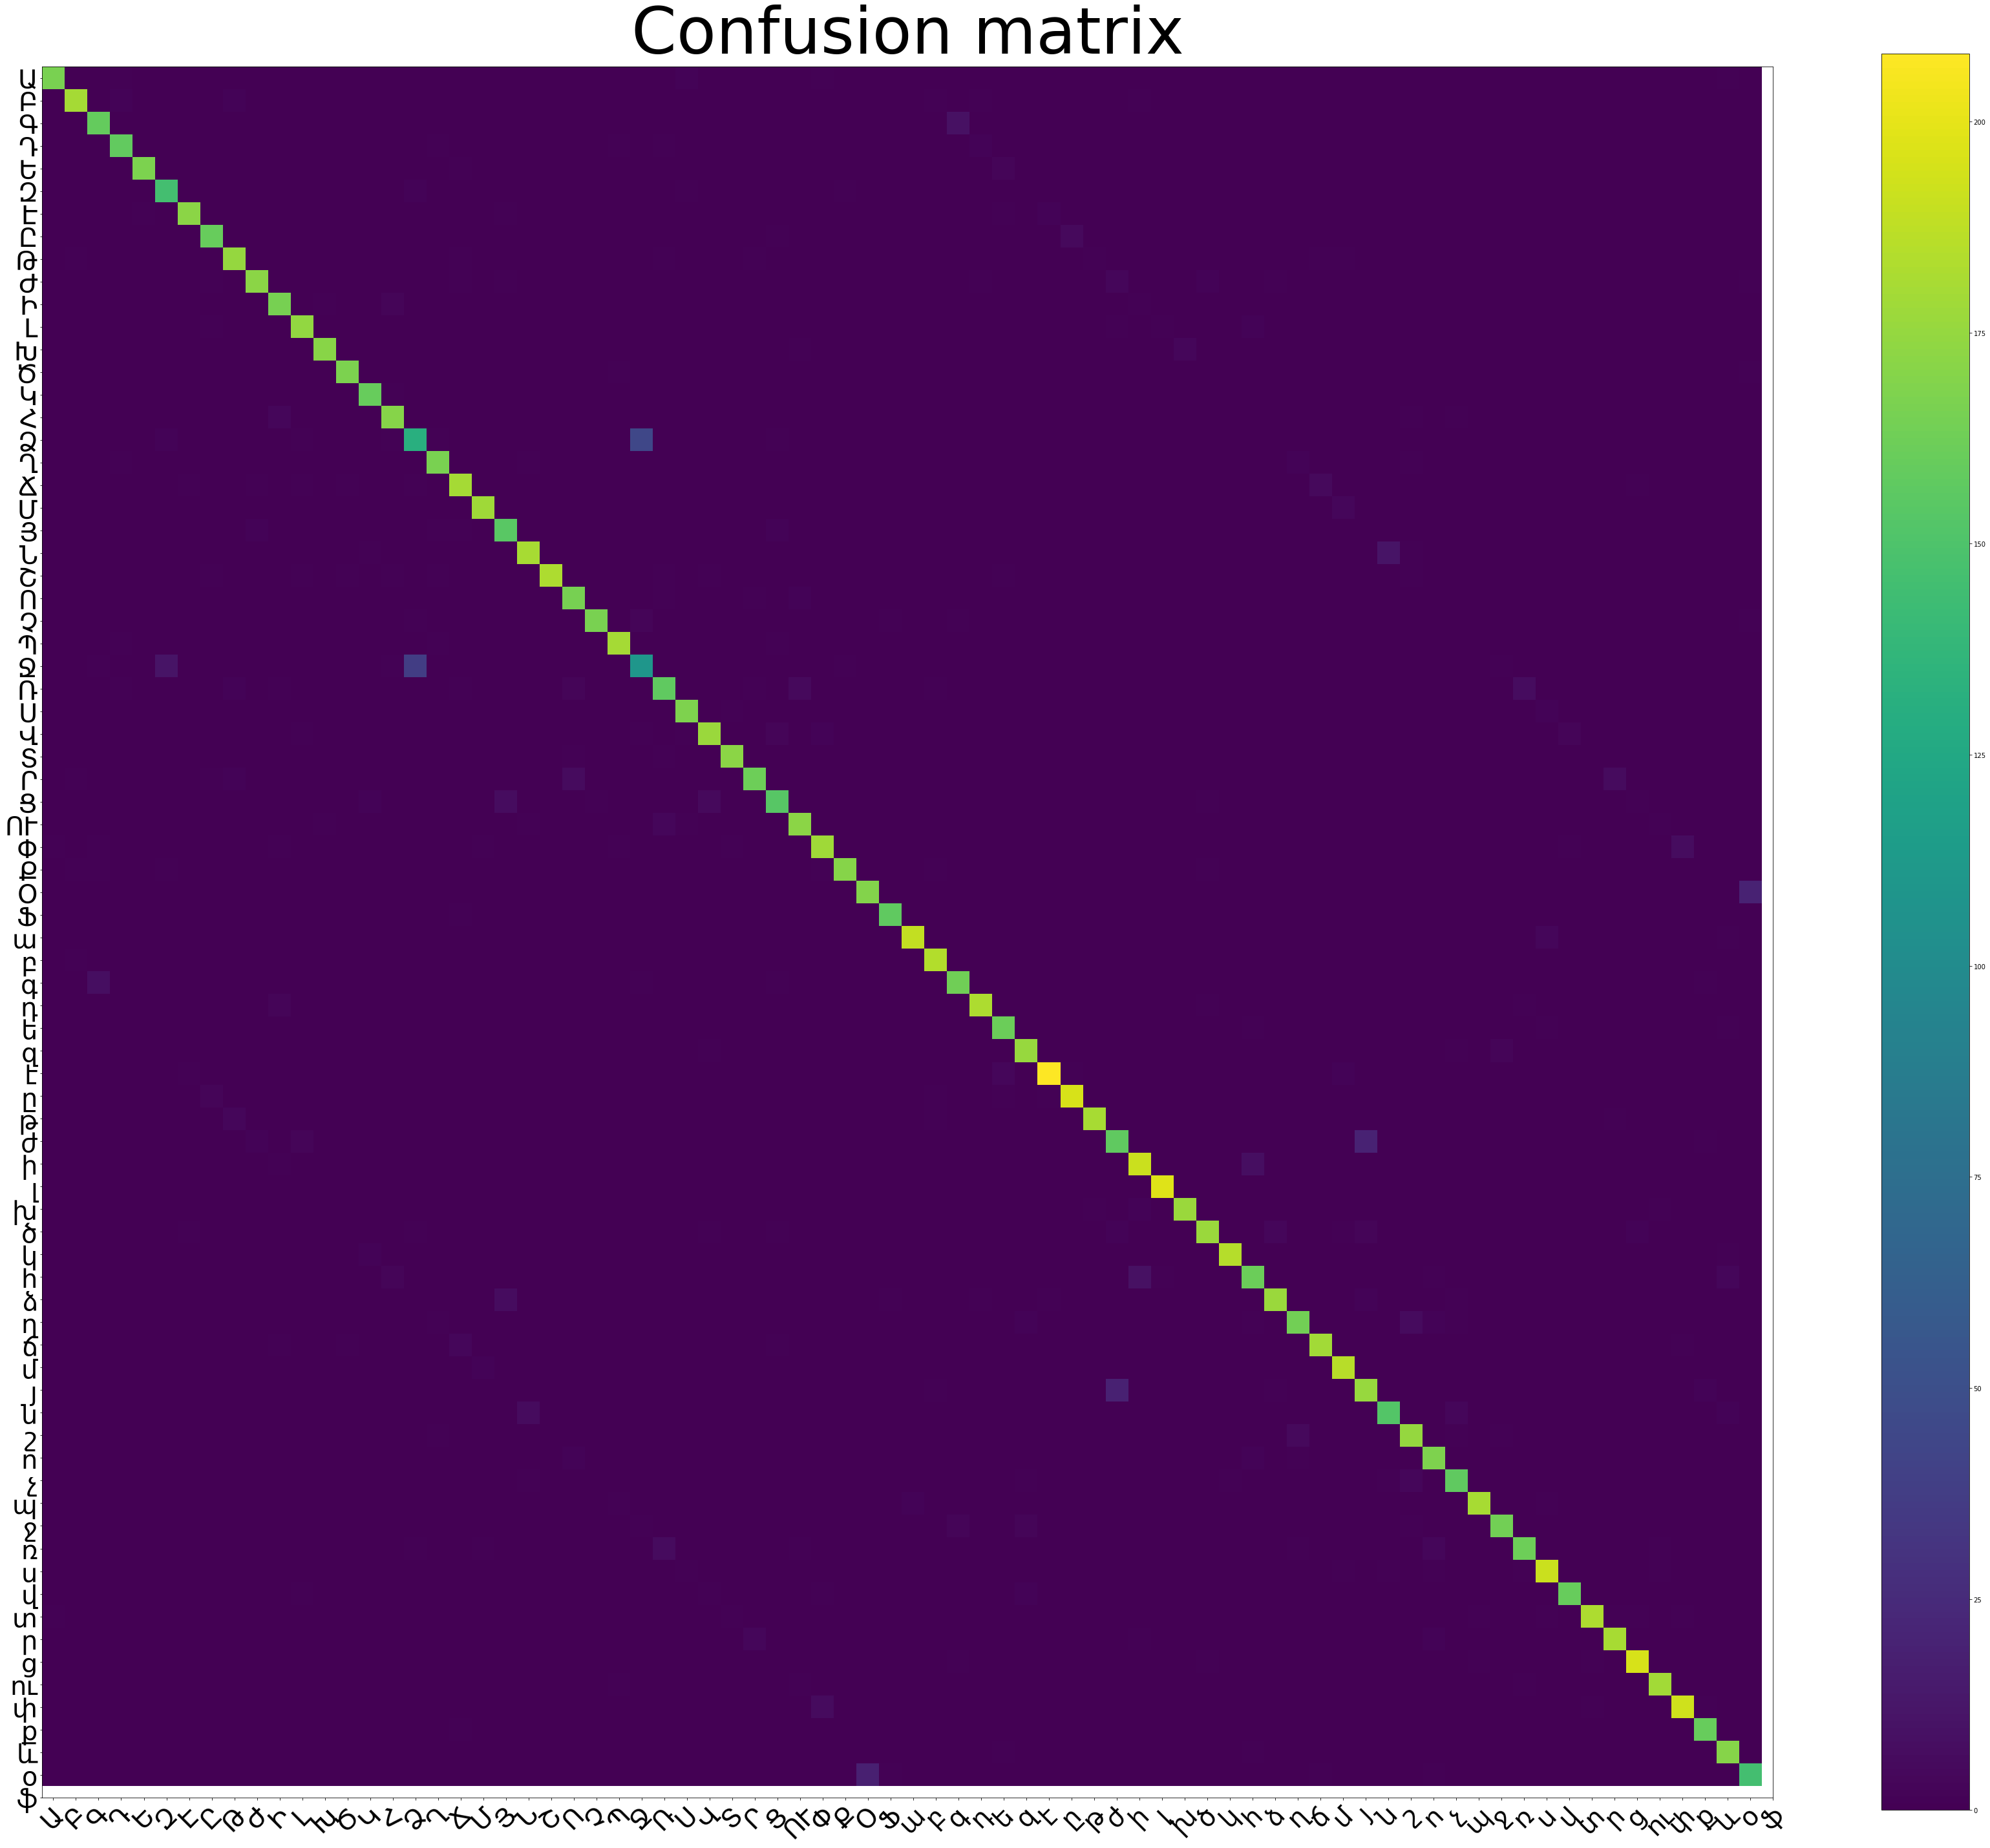

Test accuracy: 0.950058582308143


In [18]:
let_list = letters_list.copy()
let_list.remove('ԵՎ')

print(confusion_matrix(y_test_0, y_pred_classes))
plt.figure(figsize=(60, 50))
plt.title('Confusion matrix', fontsize=100)
plt.imshow(confusion_matrix(y_test_0, y_pred_classes), cmap='viridis')
plt.xticks(np.arange(77), let_list, rotation=45, fontsize=40)
plt.yticks(np.arange(77), let_list, fontsize=40)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_0, y_pred_classes))

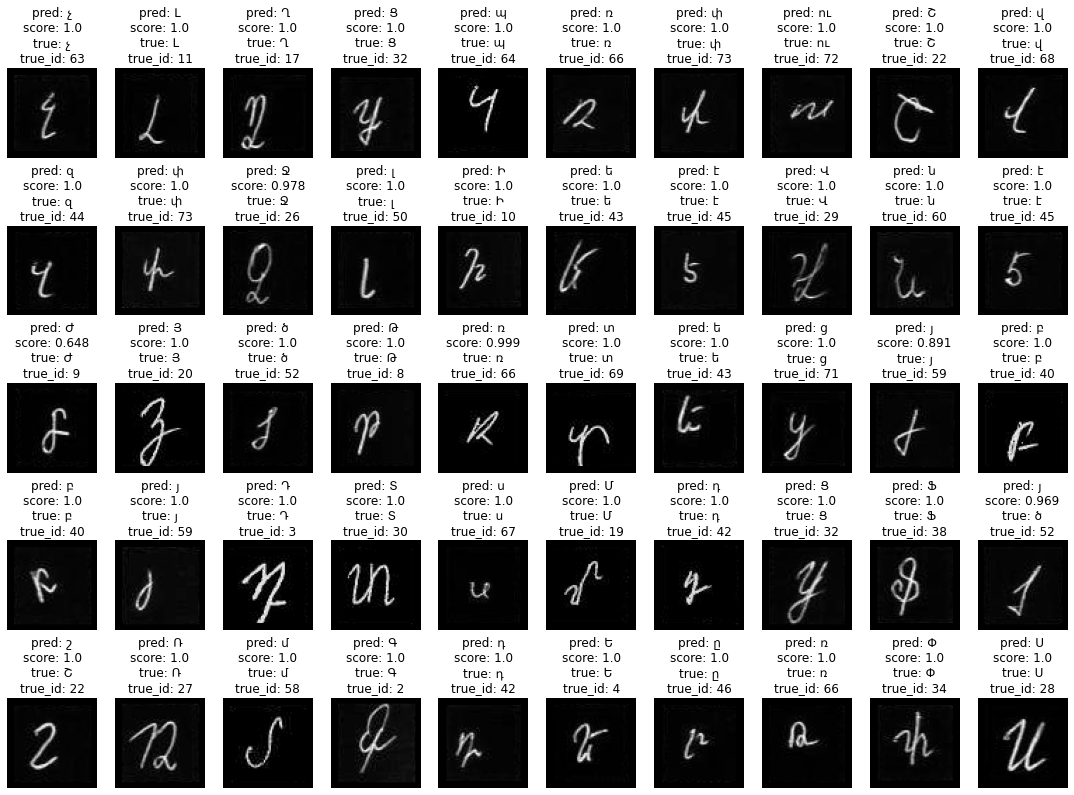

In [19]:
cols = 10
rows = 5
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test_0))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :], cmap='gray')
        pred_label = letters_list[y_pred_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label, true_id = letters_list[y_test_0[random_index]], y_test_0[random_index]
        ax.set_title(f"pred: {pred_label}\nscore: {pred_proba:.3}\ntrue: {true_label}\ntrue_id: {true_id}")
plt.show()

# Save / load model

In [20]:
# model.save("model_95")
# model_load = keras.models.load_model("model_95")

In [21]:
# model.save("model_h5_95.h5")

In [22]:
# model_load = keras.models.load_model("model_h5_95.h5")

# Test example 1

In [20]:
img_t = cv2.imread('example_images/e.jpg', cv2.IMREAD_GRAYSCALE)
print(img_t.shape)

(269, 271)


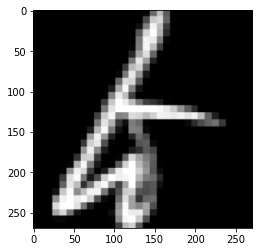

In [21]:
plt.imshow(img_t, cmap='gray');

In [22]:
ret, img_t = cv2.threshold(img_t, 100, 255, cv2.THRESH_BINARY)

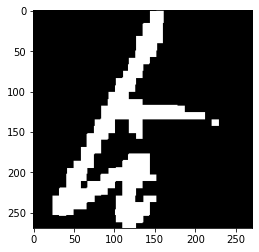

In [23]:
plt.imshow(img_t, cmap='gray');

(64, 64)
(1, 64, 64, 1)


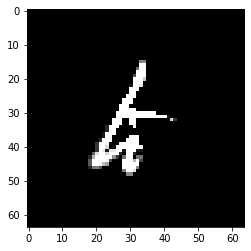

In [24]:
img_t64 = cv2.resize(img_t, (64, 64))
img_pad = np.pad(img_t64, ((30, 30), (30, 30)))
img_t64 = cv2.resize(img_pad, (64, 64))
print(img_t64.shape)
plt.imshow(img_t64, cmap='gray');
t1 = img_t64.reshape((1, 64, 64, 1))
print(t1.shape)

In [25]:
a = model_load.predict(t1)
activity_map[a.argmax()]

'ե'

In [26]:
for i, j in enumerate(a[0]):
    if j.round(5) > 0:
        print(activity_map[i], '-', j.round(5))

ե - 1.0


# Test example 2

In [27]:
img_t = cv2.imread('example_images/f.jpg', cv2.IMREAD_GRAYSCALE)
print(img_t.shape)

(147, 100)


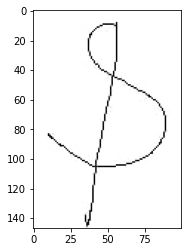

In [28]:
plt.imshow(img_t, cmap='gray');

In [29]:
ret, img_t = cv2.threshold(img_t, 100, 255, cv2.THRESH_BINARY_INV)

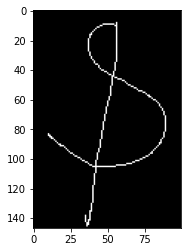

In [30]:
plt.imshow(img_t, cmap='gray');

(64, 64)
(1, 64, 64, 1)


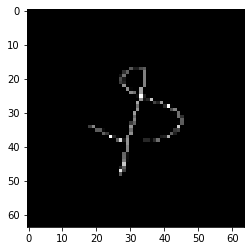

In [31]:
img_t64 = cv2.resize(img_t, (64, 64))
img_pad = np.pad(img_t64, ((30, 30), (30, 30)))
img_t64 = cv2.resize(img_pad, (64, 64))
print(img_t64.shape)
plt.imshow(img_t64, cmap='gray');
t1 = img_t64.reshape((1, 64, 64, 1))
print(t1.shape)

In [32]:
a = model_load.predict(t1)
activity_map[a.argmax()]

'Ֆ'

In [33]:
for i, j in enumerate(a[0]):
    if j.round(5) > 0:
        print(activity_map[i], '-', j.round(5))

Ֆ - 1.0


# Function for change laetter image and predict 
# (used in variant with pytesseract)

In [34]:
def change_and_predict(img, thresh=False, img_size=64, model=model_load, activity_map=activity_map, epsilon=4, min_samples=3):
    if thresh:
        ret, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY_INV)
        
    img_t64_ = cv2.resize(img, (img_size, img_size))
    img_pad = np.pad(img_t64_, ((30, 30), (30, 30)))
    img_t64 = cv2.resize(img_pad, (img_size, img_size))
    
    
    ### clustering with DBSCAN
    # generate data
    _, a = cv2.threshold(img_t64, 100, 255, cv2.THRESH_BINARY)
    a = a / 255
    data = []
    for i in range(img_size):
        for j in range(img_size):
            if a[i][j]:
                data.append([i, j])
    data = np.array(data)
    
    # clustering and find the biggest cluster
    clustering = DBSCAN(eps=epsilon, min_samples=min_samples)
    p = clustering.fit_predict(data)
    p_c = Counter(p)
    max_kay = 0
    max_value = max(p_c.values())
    for key, value in p_c.items():
        if value == max_value:
            max_key = key
    
    # filter image using cluster
    for i, j in enumerate(p):
        if j != max_key:
            a[data[i][0], data[i][1]] = 0
    
    img_64_final = a
    
    
    img_64_for_predict = img_64_final.reshape((1, img_size, img_size, 1))
    
    prob_ = model.predict(img_64_for_predict)
    letter = activity_map[prob_.argmax()]
    
    return img_64_final, prob_, letter

##### Example

(269, 271)


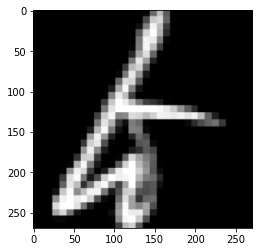

In [35]:
img_t = cv2.imread('example_images/e.jpg', cv2.IMREAD_GRAYSCALE)
print(img_t.shape)
plt.imshow(img_t, cmap='gray');

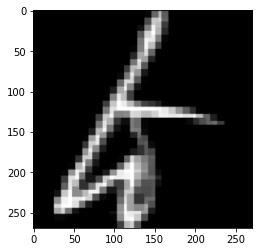

In [36]:
kernel = np.ones((5, 5), np.int8)
img_t = cv2.erode(img_t, kernel, iterations=1)
plt.imshow(img_t, cmap='gray');

ե
ե - 1.0


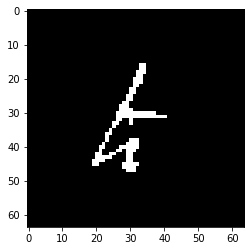

In [37]:
a10, prbs, letter = change_and_predict(img_t, thresh=False)
print(letter)

plt.imshow(a10, cmap='gray');

for i, j in enumerate(prbs[0]):
    if j.round(5) > 0:
        print(activity_map[i], '-', j.round(5))

# Predict image with Pyteseract

(701, 1280)


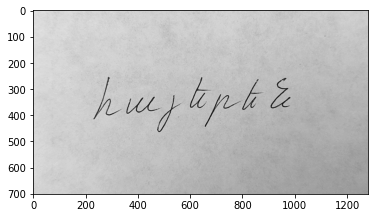

In [38]:
img = cv2.imread('example_images/2.jpg', cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img, cmap='gray');

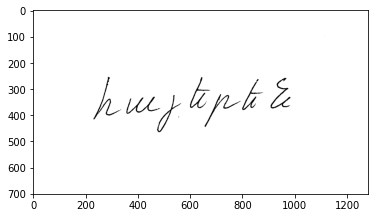

In [39]:
ret, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
plt.imshow(img, cmap='gray');

In [40]:
kernel = np.ones((5, 5), np.int8)
kernel

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=int8)

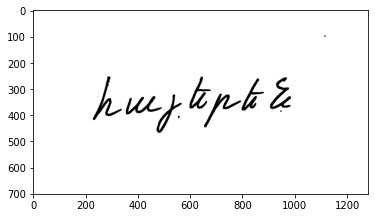

In [41]:
img = cv2.erode(img, kernel, iterations=1)
plt.imshow(img, cmap='gray');

In [42]:
# !!! your path may be different !!!
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\user\AppData\Local\Tesseract-OCR\tesseract.exe'

In [44]:
text_ = pytesseract.image_to_boxes(img, lang='eng', config=r'--oem 3 --psm 6', output_type='string')
# print(text)
text = text_.split("\n")
print(text)

['p 229 282 339 448 0', 'u 355 303 492 373 0', '} 472 233 560 379 0', 'i 598 325 679 447 0', 'p 654 254 795 382 0', 'l 797 318 846 440 0', '& 912 313 980 444 0', '']


##### Draw boxes

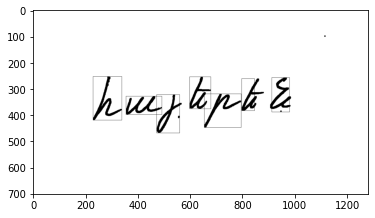

In [45]:
im = img.copy()
# h, w, c = img.shape
h, w = img.shape
for b in text_.splitlines():
    b = b.split(' ')
    img_b = cv2.rectangle(im, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 1)

plt.imshow(img_b, cmap='gray');

In [46]:
coords_list = [[int(i) for i in cds.split()[1:-1]] for cds in text if cds]
coords_list

[[229, 282, 339, 448],
 [355, 303, 492, 373],
 [472, 233, 560, 379],
 [598, 325, 679, 447],
 [654, 254, 795, 382],
 [797, 318, 846, 440],
 [912, 313, 980, 444]]

In [47]:
hsize = img.shape[0]
print(hsize)

img_boxes = [img[hsize-coords[3]:hsize-coords[1], coords[0]:coords[2] :] for coords in coords_list]
len(img_boxes)

701


7

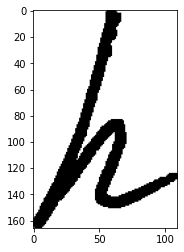

In [48]:
plt.imshow(img_boxes[0], cmap='gray');

##### Predict boxes

In [49]:
letters = []
boxes = []
probs = []
for img_box in img_boxes:
    
#     img_box = cv2.dilate(img_box, kernel, iterations=1)
    
    box, prbs, letter = change_and_predict(img_box, thresh=True)
    letters.append(letter)
    boxes.append(box)
    probs.append(prbs)

In [50]:
for i, j in enumerate(letters):
    print(f'{i}-{j}', end=' ')

0-ի 1-ա 2-յ 3-ե 4-Ր 5-Ը 6-Հ 

In [51]:
k = 2

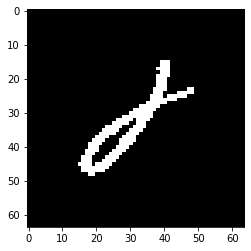

In [52]:
plt.imshow(boxes[k], cmap='gray');

In [53]:
for i, j in enumerate(probs[k][0]):
    if j.round(5) > 0:
        print(activity_map[i], '-', j.round(3))

Ժ - 0.0
ժ - 0.118
յ - 0.882


# Predict image with Contour detection

##### Find contours

In [54]:
def find_characters(img_path):
    inputImage = cv2.imread(img_path)
    inputCopy = inputImage.copy()
    
    grayscaleImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
    windowSize = 31
    windowConstant = -10
    
#     binaryImage = cv2.adaptiveThreshold(grayscaleImage, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, windowSize, windowConstant)
    ret, binaryImage = cv2.threshold(grayscaleImage, 110, 255, cv2.THRESH_BINARY_INV)
    
#     binaryImage = cv2.Canny(binaryImage, 30, 150)
    
    kernelSize = 3
    opIterations = 3
    
    maxKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelSize, kernelSize))

    closingImage = cv2.morphologyEx(binaryImage, cv2.MORPH_CLOSE, maxKernel, None, None, opIterations, cv2.BORDER_REFLECT101)

    contours, hierarchy = cv2.findContours(closingImage, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    contours_poly = [None] * len(contours)

    boundRect = []
    ind = []

    for i, c in enumerate(contours):

        if hierarchy[0][i][3] == -1:
            ind.append(i)
            contours_poly[i] = cv2.approxPolyDP(c, 3, True)  # 0.01 * cv2.arcLength(c, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))

            
    conture = []
    boxes = []
    for i in range(len(boundRect)):
        color = (0, 255, 0)
        (x, y, w, h) = boundRect[i]
        if boundRect[i][2] > 40 and boundRect[i][2] < 500:
            conture.append(contours[ind[i]])
            cv2.rectangle(inputCopy, (x, y), (x+w+10, y+h+10), color, 2)
            boxes.append([x, y, x + w + 10, y + h + 10])

    return inputImage, inputCopy, boxes

In [55]:
img, img_boxes, boxes = find_characters('example_images/2.jpg')

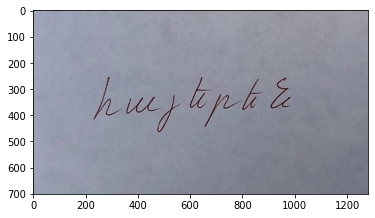

In [56]:
plt.imshow(img);

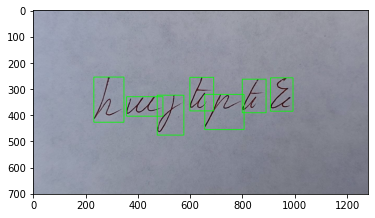

In [57]:
plt.imshow(img_boxes);

In [58]:
boxes

[[357, 330, 496, 404],
 [474, 324, 576, 476],
 [656, 321, 806, 455],
 [799, 263, 890, 391],
 [907, 258, 993, 385],
 [599, 256, 690, 384],
 [232, 255, 347, 427]]

In [59]:
img_letters = []
for i in boxes:
    x_min, y_min, x_max, y_max = i
    img_letters.append(img[y_min:y_max, x_min:x_max])
len(img_letters)

7

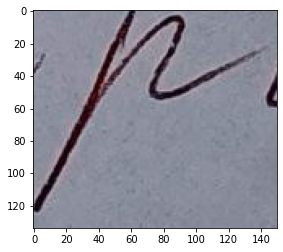

In [60]:
plt.imshow(img_letters[2]);

##### Change and predict contours

In [61]:
def change_and_predict_contours(img, thresh=False, img_size=64, model=model_load, activity_map=activity_map, epsilon=4, min_samples=3):
    
    # to grayscale if not
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # thresholding
    ret, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3, 3), np.int8)
    img = cv2.erode(img, kernel, iterations=1)
    
    if thresh:
        ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV)
    
    # resize
    img_64_full = cv2.resize(img, (img_size, img_size))
    img_pad = np.pad(img_64_full, ((30, 30), (30, 30)))
    img_64_ready = cv2.resize(img_pad, (img_size, img_size))
    
    
    ### clustering with DBSCAN
    # generate data
    _, a = cv2.threshold(img_64_ready, 100, 255, cv2.THRESH_BINARY)
    a = a / 255
    data = []
    for i in range(img_size):
        for j in range(img_size):
            if a[i][j]:
                data.append([i, j])
    data = np.array(data)
    
    # clustering and find the biggest cluster
    clustering = DBSCAN(eps=epsilon, min_samples=min_samples)
    p = clustering.fit_predict(data)
    p_c = Counter(p)
    max_kay = 0
    max_value = max(p_c.values())
    for key, value in p_c.items():
        if value == max_value:
            max_key = key
    
    # filter image using cluster
    for i, j in enumerate(p):
        if j != max_key:
            a[data[i][0], data[i][1]] = 0
    
    img_64_final = a
    
    
    # predict
    for_predict = img_64_final.reshape((1, img_size, img_size, 1))
    prob = model.predict(for_predict)
    letter = activity_map[prob.argmax()]
    
    return img_64_final, prob, letter

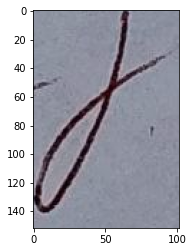

In [62]:
plt.imshow(img_letters[1]);

In [63]:
letters_final = []
boxes_final = []
probs_final = []

for img_box in img_letters:
    box, prbs, letter = change_and_predict_contours(img_box, thresh=True)
    letters_final.append(letter)
    boxes_final.append(box)
    probs_final.append(prbs)

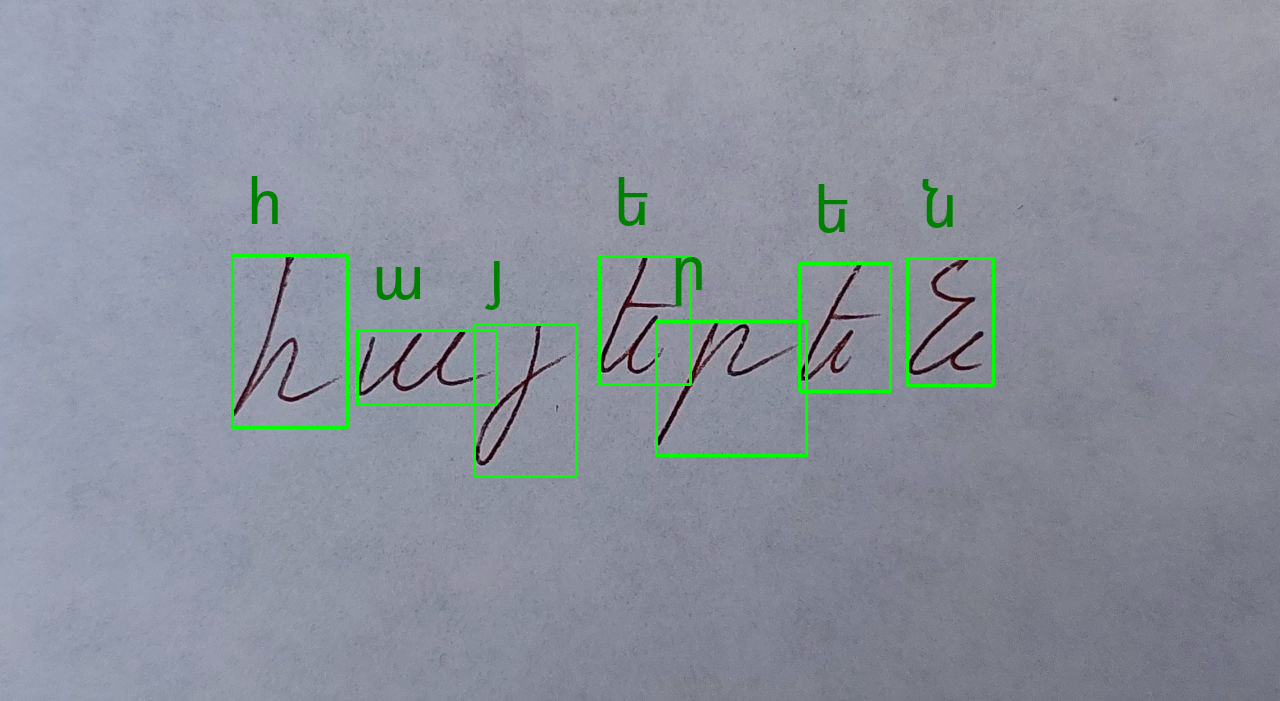

In [64]:
img_copy = Image.fromarray(img_boxes)

font = ImageFont.truetype("fonts/GHEAGrpalatReg.otf", 64)

for i in range(len(letters_final)):
    img_draw = ImageDraw.Draw(img_copy)
    img_draw.text((boxes[i][0] + 15, boxes[i][1] - 100), text=letters_final[i], fill='green', font=font)
    
img_copy

In [65]:
for i, j in enumerate(letters_final):
    print(f'{i}-{j}', end='\t')

0-ա	1-յ	2-ր	3-ե	4-ն	5-ե	6-հ	

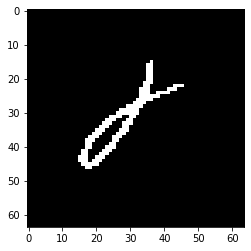

In [66]:
plt.imshow(boxes_final[1], cmap='gray');

#### Example of filtering image with clustering

(64, 64)


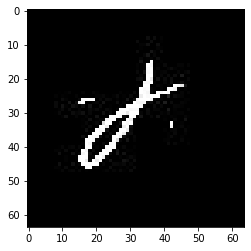

In [67]:
let_img = cv2.imread('example_images/letter_filter_example.jpg', cv2.IMREAD_GRAYSCALE)
print(let_img.shape)
plt.imshow(let_img, cmap='gray');

In [68]:
_, let_img = cv2.threshold(let_img, 100, 255, cv2.THRESH_BINARY)

In [69]:
let_img = let_img / 255

In [70]:
data = []
for i in range(64):
    for j in range(64):
        if let_img[i][j]:
            data.append([i, j])

In [71]:
data = np.array(data)
data.shape
# data

(156, 2)

In [72]:
clustering = DBSCAN(eps=4, min_samples=3)
p = clustering.fit_predict(data)
p

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  1,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int64)

In [73]:
p_c = Counter(p)
p_c

Counter({0: 148, 1: 6, -1: 2})

In [74]:
max_kay = 0
max_value = max(p_c.values())
for key, value in p_c.items():
    if value == max_value:
        max_key = key

In [75]:
max_key

0

In [76]:
for i, j in enumerate(p):
    if j != max_key:
        let_img[data[i][0], data[i][1]] = 0

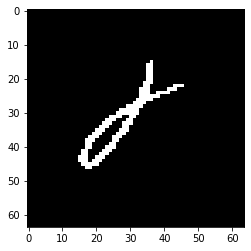

In [77]:
plt.imshow(let_img, cmap='gray');